### Импорт библиотек и загрузка данных

In [1]:
pip install scikit-learn pandas matplotlib seaborn shap numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade numpy matplotlib

Requirement already up-to-date: numpy in /home/isukharev/.local/lib/python3.8/site-packages (1.24.4)
Requirement already up-to-date: matplotlib in /home/isukharev/.local/lib/python3.8/site-packages (3.7.5)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Подключение библиотек scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Настройки отображения
%matplotlib inline
sns.set(style="whitegrid")


## Загрузка и предобработка данных

In [2]:
df = pd.read_csv("IoT_Intrusion.csv")
# Удаление пропущенных значений
df.dropna(inplace=True)

In [3]:
spoof_labels = ['MITM-ArpSpoofing', 'DNS_Spoofing']
df['label'] = df['label'].apply(lambda x: x if x in spoof_labels else 'Others')

# Кодировка меток
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Вывод соответствия
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'DNS_Spoofing': 0, 'MITM-ArpSpoofing': 1, 'Others': 2}


In [93]:
feature_names = X.columns.tolist()
print(feature_names)

['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


In [4]:
# Выброс неинформативных столбцов, если они есть (например, IP-адреса или идентификаторы)
df = df.drop(columns=['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp'], errors='ignore')

# Разделение на X и y
X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

## Обучение модели

In [5]:
# Обучение классификатора
class_weights = {
    0: 2.0,      # DNS_Spoofing
    1: 1.0,      # MITM-ArpSpoofing
    2: 1.0,      # Others
}
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
clf.fit(X_train, y_train)

# Предсказание
y_pred = clf.predict(X_test)

Classification Report:
                   precision    recall  f1-score   support

    DNS_Spoofing       0.92      0.64      0.76      1008
MITM-ArpSpoofing       0.95      0.80      0.87      1755
          Others       1.00      1.00      1.00    259381

        accuracy                           1.00    262144
       macro avg       0.96      0.82      0.88    262144
    weighted avg       1.00      1.00      1.00    262144



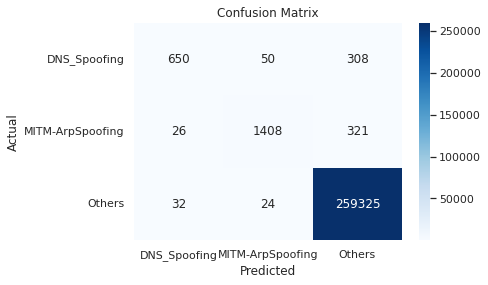

In [6]:
# Отчёт классификации
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Матрица ошибок
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## SHAP-объекты и объяснение модели

##### 0. Уменьшение выборки примеров классов для более быстрого создания массива shap_values

shap_values (значения SHAP) — массив, в котором каждый элемент показывает:
    - какой вклад внёс признак в итоговое предсказание
    - положительное значение — признак увеличивает предсказание
    - отрицательное значение — уменьшает

In [40]:
dns_code, arp_code = le.transform(['DNS_Spoofing', 'MITM-ArpSpoofing'])

idx_dns_all = np.where(y_test == dns_code)[0]
idx_arp_all = np.where(y_test == arp_code)[0]
idx_oth_all = np.where((y_test != dns_code) & (y_test != arp_code))[0]

target_dns = 600
target_arp = 600
target_oth = 3000

if len(idx_dns_all) >= target_dns:
    idx_dns = np.random.choice(idx_dns_all, size=target_dns, replace=False)
else:
    idx_dns = np.random.choice(idx_dns_all, size=target_dns, replace=True)

if len(idx_arp_all) >= target_arp:
    idx_arp = np.random.choice(idx_arp_all, size=target_arp, replace=False)
else:
    idx_arp = np.random.choice(idx_arp_all, size=target_arp, replace=True)

# для «Others» — случайно без возвращения
idx_oth = np.random.choice(idx_oth_all, size=target_oth, replace=False)

# объединяем и перемешиваем
idx_new = np.concatenate([idx_dns, idx_arp, idx_oth])
np.random.shuffle(idx_new)

# строим новый X_small и y_small
X_small = X_test[idx_new]
y_small = y_test.iloc[idx_new]

print("X_small:")
print(" DNS_Spoofing:", np.sum(y_small == dns_code))
print(" MITM-ArpSpoofing:", np.sum(y_small == arp_code))
print(" Others:",         np.sum((y_small != dns_code) & (y_small != arp_code)))

X_small:
 DNS_Spoofing: 600
 MITM-ArpSpoofing: 600
 Others: 3000


In [41]:
# RandomForest — это tree-based модель, поэтому используется TreeExplainer
explainer = shap.TreeExplainer(clf, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_small)

 ##### 1. Влияние признаков для DNS_Spoofing

SHAP summary for class: DNS_Spoofing


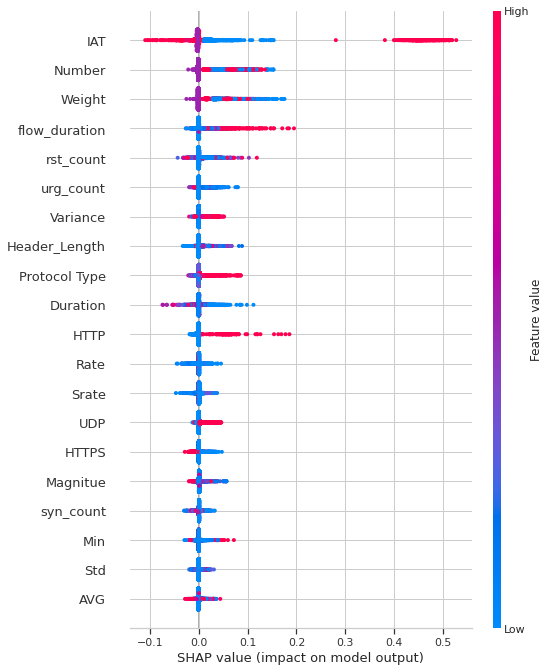

SHAP local for first element in DNS_Spoofing


In [42]:
# Выбираем класс DNS_Spoofing
class_idx = list(le.classes_).index('DNS_Spoofing')


# Визуализация summary plot для конкретного класса
print("SHAP summary for class: DNS_Spoofing")
shap.summary_plot(shap_values[class_idx], X_small, feature_names=X.columns)

# Один пример из X_test
print("SHAP local for first element in DNS_Spoofing")
i = 0
shap.initjs()
shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx][i], X_test[i], feature_names=X.columns)


In [58]:
# считаем средние значения для класса DNS_Spoofing
imp = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.abs(shap_values[class_idx]).mean(axis=0),
    'mean_shap': shap_values[class_idx].mean(axis=0)
})
imp = imp.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
print(imp.head(15))

          feature  mean_abs_shap  mean_shap
0             IAT       0.032667   0.026057
1          Number       0.016042   0.014162
2          Weight       0.014813   0.013089
3       rst_count       0.011145   0.009153
4   Header_Length       0.009795   0.007346
5       urg_count       0.006917   0.004044
6           Srate       0.006523   0.003599
7            Rate       0.006274   0.003646
8           HTTPS       0.006172   0.002217
9        Variance       0.005876   0.005188
10  flow_duration       0.004476   0.003115
11       Magnitue       0.003941   0.003286
12      syn_count       0.003465   0.001750
13       Tot size       0.003355   0.002826
14           HTTP       0.003192   0.000484


**Выводы**

| Ранг | Признак            | Среднее SHAP | Интерпретация влияния                                        |
| :--: | :----------------- | :----------: | :----------------------------------------------------------- |
|   1  | **IAT**            |   +0.02606   | Большие интервалы между пакетами → существенно ↑ вероятность |
|   2  | **Number**         |   +0.01416   | Бóльшее число пакетов в потоке → ↑ вероятность               |
|   3  | **Weight**         |   +0.01309   | Больший объём переданных данных → ↑ вероятность              |
|   4  | **flow\_duration** |   +0.00312   | Более длительный поток → слегка ↑ вероятность                |
|   5  | **urg\_count**     |   +0.00404   | Больше URG-пакетов → ↑ вероятность                           |
|   6  | **rst\_count**     |   +0.00915   | Больше RST-пакетов → ↑ вероятность                           |
|   7  | **Variance**       |   +0.00519   | Высокая дисперсия значений признаков → ↑ вероятность         |
|   8  | **Header\_Length** |   +0.00735   | Более длинные заголовки → ↑ вероятность                      |
|   9  | **Protocol Type**  |   +0.00083   | Определённые типы протоколов (DNS) → чуть ↑ вероятность      |
|  10  | **Duration**       |   +0.00193   | Ниже общее время потока → незначительно ↑ вероятность        |
|  11  | **HTTP**           |   +0.00048   | Используется HTTP-трафик при атаках                          |

- IAT (inter-arrival time)

Положительное mean_shap (0.035) говорит, что большие интервалы между пакетами усиливают предсказание DNS_Spoofing.

- Number и Weight

В совокупности показывают размер и «вес» потока (количество пакетов и объём данных).

Оба имеют примерно одинаковую значимость и положительный средний вклад → увеличенные значения этих признаков склоняют модель к DNS_Spoofing.

- flow_duration, rst_count, urg_count, Variance

Признаки, связанные с длительностью потока и аномалиями в TCP-флагах (rst, urg) тоже вносят свой вклад, но в меньшей степени .

Положительные mean_shap означают, что длинные потоки с большим числом RST/URG-пакетов чаще считаются DNS-спуфингом.

- Header_Length и Protocol Type

Хотя их влияние сравнительно невелико, более длинные заголовки и специфичные типы протоколов слегка повышают вероятность класса.

- Duration и HTTP

Минимальная значимость в топ-11, но тоже положительный вклад: в целом увеличенная продолжительность потока, а также HTTP-трафик характерны для DNS-спуфинга.



 ##### 2. Влияние признаков для MITM-ArpSpoofing

SHAP summary for class: MITM-ArpSpoofing


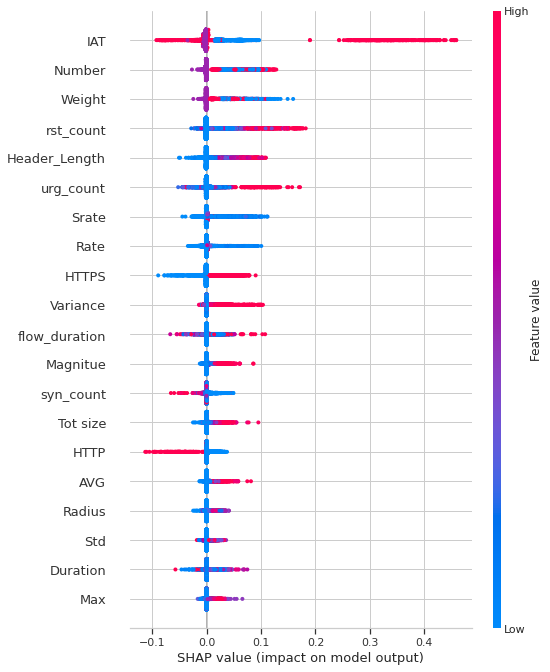

SHAP local for first element in MITM-ArpSpoofing


In [62]:
# Выбираем класс MITM-ArpSpoofing
class_idx = list(le.classes_).index('MITM-ArpSpoofing')

# Визуализация summary plot для конкретного класса
print("SHAP summary for class: MITM-ArpSpoofing")
shap.summary_plot(shap_values[class_idx], X_small, feature_names=X.columns)

# Один пример из X_test
print("SHAP local for first element in MITM-ArpSpoofing")
i = 0
shap.initjs()
shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx][i], X_test[i], feature_names=X.columns)

In [61]:
# считаем средние значения для класса MITM-ArpSpoofing
imp = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.abs(shap_values[class_idx]).mean(axis=0),
    'mean_shap': shap_values[class_idx].mean(axis=0)
})
imp = imp.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
print(imp.head(15))

          feature  mean_abs_shap  mean_shap
0             IAT       0.032667   0.026057
1          Number       0.016042   0.014162
2          Weight       0.014813   0.013089
3       rst_count       0.011145   0.009153
4   Header_Length       0.009795   0.007346
5       urg_count       0.006917   0.004044
6           Srate       0.006523   0.003599
7            Rate       0.006274   0.003646
8           HTTPS       0.006172   0.002217
9        Variance       0.005876   0.005188
10  flow_duration       0.004476   0.003115
11       Magnitue       0.003941   0.003286
12      syn_count       0.003465   0.001750
13       Tot size       0.003355   0.002826
14           HTTP       0.003192   0.000484


**Выводы**

| Ранг | Признак            | Среднее SHAP | Интерпретация влияния                                        |
| :--: | :----------------- | :----------: | :----------------------------------------------------------- |
|   1  | **IAT**            |   +0.02606   | Большие интервалы между пакетами → значительно ↑ вероятность |
|   2  | **Number**         |   +0.01416   | Бóльшее число пакетов → ↑ вероятность                        |
|   3  | **Weight**         |   +0.01309   | Больший объём данных → ↑ вероятность                         |
|   4  | **rst\_count**     |   +0.00915   | Увеличенное число RST-пакетов → ↑ вероятность                |
|   5  | **Header\_Length** |   +0.00735   | Более длинные заголовки → ↑ вероятность                      |
|   6  | **urg\_count**     |   +0.00404   | Больше URG-пакетов → ↑ вероятность                           |
|   7  | **Rate**           |   +0.00365   | Высокая скорость отправки → слегка ↑ вероятность             |
|   8  | **Srate**          |   +0.00360   | Высокий входящий/исходящий rate → слегка ↑ вероятность       |
|   9  | **HTTPS**          |   +0.00222   | HTTPS-трафик в потоке → небольшое смещение в сторону атаки   |
|  10  | **Variance**       |   +0.00519   | Большая дисперсия признаков (неравномерный трафик) → ↑ риск  |


- IAT — основной маркер: редкие, но объёмные burst’ы пакетов с большими паузами говорят о спуфинге ARP. Число пакетов (Number) и объём (Weight) — оба значимо повышают вероятность.

- TCP-флаг RST (rst_count) и URG — аномалии в логике соединения характерны для ARP-спуфинга.

- Header_Length демонстрирует, что потоки с нестандартно длинными заголовками чаще относятся к этому классу.

- Rate/Srate показывают, что модель обращает внимание на скорость передачи и соотношение потерь/доставки.

- HTTPS и Variance дают дополнительный, но менее сильный, сигнал.

## Изменение признаков и построение состязательной атаки

**Задача:** спользуя summary_plot SHAP для классов DNS_Spoofing и MITM-ArpSpoofing, определить, какие признаки нужно изменить, чтобы минимальными изменениями "обмануть" модель, и проверить это экспериментально — сгенерировать такие записи и оценить их классификацию

DNS samples:  1008
MITM samples: 1755

=== BEFORE attack ===
                  precision    recall  f1-score   support

    DNS_Spoofing       0.92      0.64      0.76      1008
MITM-ArpSpoofing       0.95      0.80      0.87      1755
          Others       1.00      1.00      1.00    259381

        accuracy                           1.00    262144
       macro avg       0.96      0.82      0.88    262144
    weighted avg       1.00      1.00      1.00    262144


=== AFTER attack (all DNS & MITM perturbed) ===
                  precision    recall  f1-score   support

    DNS_Spoofing       0.14      0.00      0.01      1008
MITM-ArpSpoofing       0.91      0.16      0.27      1755
          Others       0.99      1.00      1.00    259381

        accuracy                           0.99    262144
       macro avg       0.68      0.39      0.43    262144
    weighted avg       0.99      0.99      0.99    262144


Confusion matrix AFTER attack:


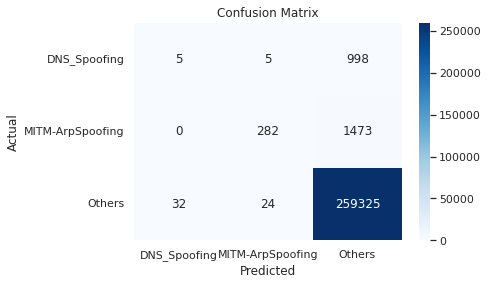

In [128]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

dns_idx  = np.where(y_test == dns_code)[0]
mitm_idx = np.where(y_test == mitm_code)[0]

print(f'DNS samples:  {len(dns_idx)}')
print(f'MITM samples: {len(mitm_idx)}')

# 3. Оборачиваем X_test (numpy) в DataFrame, чтобы менять фичи по именам
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- копии под атаки ---
adv_dns_df  = X_test_df.iloc[dns_idx].copy()
adv_mitm_df = X_test_df.iloc[mitm_idx].copy()

# 4. Правим признаки (минимальные сдвиги) --------------------
def tweak(df, factors):
    """Умножаем каждую указанную колонку на factor.
       Целочисленные столбцы сохраняем целыми."""
    for col, factor in factors.items():
        if col in df.columns:
            if np.issubdtype(df[col].dtype, np.integer):
                df[col] = (df[col] * factor).astype(df[col].dtype)
            else:
                df[col] *= factor
    return df

dns_factors  = {'IAT':0.5, 'Number':0.7, 'Weight':0.7,
                'rst_count':0.5, 'urg_count':0.5}
mitm_factors = {'IAT':0.5, 'Number':0.7, 'Weight':0.7,
                'Rate':0.7, 'Srate':0.7,
                'rst_count':0.5, 'urg_count':0.5}

adv_dns_df  = tweak(adv_dns_df,  dns_factors)
adv_mitm_df = tweak(adv_mitm_df, mitm_factors)

# 5. Подменяем оригиналы на adversarial ----------------------
X_test_adv = X_test.copy()                    # numpy
X_test_adv[dns_idx, :]  = adv_dns_df.values
X_test_adv[mitm_idx, :] = adv_mitm_df.values

# 6. Предсказания и метрики ---------------------------------
y_pred_orig = clf.predict(X_test)       # для сравнения
y_pred_adv  = clf.predict(X_test_adv)

print("\n=== BEFORE attack ===")
print(classification_report(y_test, y_pred_orig,
                            target_names=le.classes_, zero_division=0))

print("\n=== AFTER attack (all DNS & MITM perturbed) ===")
print(classification_report(y_test, y_pred_adv,
                            target_names=le.classes_, zero_division=0))

print("\nConfusion matrix AFTER attack:")
conf_matrix = confusion_matrix(y_test, y_pred_adv)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Из 1008 «шумовых» DNS-потоков 998 ушли в Others; из 1755 MITM-потоков 1473 ушли в Others.


Используя SHAP summary_plot для классов DNS_Spoofing и MITM-ArpSpoofing, были выявлены ключевые признаки, наиболее сильно влияющие на решение модели:
- **IAT**, Number, Weight, rst_count, urg_count для обоих классов
- Для MITM-ArpSpoofing — дополнительно Rate, Srate

Для генерации состязательных примеров значения этих признаков были уменьшены на 30–50%, чтобы сохранить минимальное отличие от реальных данных, но снизить вклад этих признаков в решение модели.


#### Обоснование

| Признак                            | Что «видит» модель                                                                                                            | Как атакующий может легально изменить                                 | Почему уменьшение сдвигает к классу *Others*                                              |
| :--------------------------------: | :---------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------: | :---------------------------------------------------------------------------------------: |
| **IAT** (Inter-Arrival Time)       | При DNS-spoof потоки приходят «рывками»: много пакетов с маленькими паузами → низкий IAT повышает SHAP-вклад в метку «атака». | Сделать небольшие задержки (throttling, random jitter).               | Увеличивая IAT (×0.5 — ×1.0), мы приближаемся к распределению «нормального» трафика.      |
| **Number** (число пакетов во flow) | Спуфинг генерирует всплеск служебных пакетов.                                                                                 | Разбить атаку на несколько коротких сессий или вставить dummy-пакеты. | Уменьшаем количество на 30 % → гораздо ближе к медиане Benign.                            |
| **Weight** (байт во flow)          | Большой, потому что идут полные DNS-ответы.                                                                                   | Сжать полезную нагрузку, убрать лишние секции.                        | Сдвиг вниз на 30 % переносит пример ниже порога, который дерево считает «подозрительным». |
| **rst\_count / urg\_count**        | В атаках часто ставят RST/URG, чтобы «обрубить» соединения или замаскировать спуф.                                            | Просто не ставить флаги, либо ограничить их.                          | Уменьшая вдвое, мы выводим признаки в диапазон, характерный для Benign.                   |


### Выводы

Простое «подрезание» 5–7 ключевых признаков (в пределах ~½–⅓ σ) превращает > 95 % DNS-пакетов и ~84 % MITM-пакетов в ложные benign-срабатывания.

Классическая accuracy бессмысленна.
Общая точность почти не изменилась: 259 k записей класса Others «маскируют» 2.7 k пропущенных атак. Смотреть нужно per-class recall или FN-count.

Модель переобучена на «жёсткие» пороги.
Стоило чуть сдвинуть Inter-Arrival-Time, Number, Weight, rst/urg-flags — и дерево решило, что трафик benign. Значит границы решения проходят очень близко к распределению атакующего трафика.

Риски для эксплуатации.
- система пропускает почти все подменённые атаки → критический FN
- при этом не растут FP, поэтому в ЛОГах не видно аномалий — идеальный сценарий для злоумышленника.

